# Transfer Learning with ResNet-50 for Deep Space Object Classification

**ResNet** is a deep convolutional neural network architecture that uses shortcut (residual) connections to enable training of very deep networks by mitigating the vanishing gradient problem. Its seminal paper, "[Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)" by He et al. (2015), demonstrated that these residual connections allow models to achieve state-of-the-art performance on challenging image recognition tasks.

In this notebook ResNet-50 is used as a base model for performing Transfer Learning on [ImageNet](https://www.google.com/url?q=https%3A%2F%2Fwww.image-net.org%2Fabout.php), using a custom deep spece objects (DSO) dataset.

In Transfer Learning, we take the pre-trained weights, which learned general image features, and reuse them for a new classification task on our own dataset. This approach usually speeds up training and can improve accuracy when the new dataset is smaller or less diverse than ImageNet.

## 1. Add imports

We import TensorFlow(2.18.0) / Keras for building and training. We use **matplotlib** for plotting metrics and **numpy** for numerical operations.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

from tqdm import tqdm



# 2. Dataset

In this section, we will load our deep space objects dataset. It includes images from galaxies, nebulae, and star clusters. We will pull it from Google Drive, then split it into train, validation, and test sets. We will also apply basic preprocessing such as input resizing, normalization, etc.

## 2.1 Google Drive mounting


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## 2.2 Data splitting for Training and Validation

The dataset is structured into train, validation, and test directories.
We use mild data augmentation techniques appropriate for astronomy to simulate various telescope angles and centering issues without distorting the structure of deep space objects.

In [ ]:
base_dir = '/content/drive/MyDrive/Transfer Learning in Astronomy/ODATA_FINAL'

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = test_val_datagen.flow_from_directory(
    os.path.join(base_dir, 'validation'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_val_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print("Class indices:", train_generator.class_indices)


Found 1251 images belonging to 4 classes.
Found 311 images belonging to 4 classes.
Found 389 images belonging to 4 classes.
Class indices: {'clusters': 0, 'galaxies': 1, 'nebulae': 2, 'other': 3}



*   `rotation_range=30`	Objects like galaxies and nebulae can appear in any angle
*   `horizontal_flip`	Telescope images can vary in orientation
*   `zoom_range=0.1`	Slight scale changes simulate object distance variations
*   `width/height shift`	Accounts for minor telescope drift or cropping variation
*   `fill_mode='nearest'`	Avoids artifacts at borders when shifting/rota


### 2.3 Data Exploration

In [ ]:
from collections import Counter

class_counts = Counter(train_generator.classes)
print("Images per class (train):")
for class_index, count in class_counts.items():
    class_name = list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(class_index)]
    print(f"{class_name}: {count} images")

val_counts = Counter(val_generator.classes)
print("\nImages per class (validation):")
for class_index, count in val_counts.items():
    class_name = list(val_generator.class_indices.keys())[list(val_generator.class_indices.values()).index(class_index)]
    print(f"{class_name}: {count} images")

test_counts = Counter(test_generator.classes)
print("\nImages per class (test):")
for class_index, count in test_counts.items():
    class_name = list(test_generator.class_indices.keys())[list(test_generator.class_indices.values()).index(class_index)]
    print(f"{class_name}: {count} images")


Images per class (train):
clusters: 302 images
galaxies: 305 images
nebulae: 327 images
other: 317 images

Images per class (validation):
clusters: 75 images
galaxies: 76 images
nebulae: 81 images
other: 79 images

Images per class (test):
clusters: 94 images
galaxies: 95 images
nebulae: 102 images
other: 98 images


##3. Import ResNet-50 Model and Build the Classifier


## 3.1 Load and Inspect the ResNet-50 Architecture

We load ResNet-50 without the top layers and freeze it to retain the powerful features learned from ImageNet.

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

## 3.2 Freeze the Pre-Trained Layers

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

## 3.3 Build a New Classifier on Top

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,689,988 (98.00 MB)

 Trainable params: 2,102,276 (8.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# 4. Train the model

**We** use the Adam optimizer and categorical crossentropy loss function for multi-class classification.

Using checkpoint will automatically save the model during training — we can resume training from the latest checkpoint

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0002),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Transfer Learning in Astronomy/best_resnet50.keras',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',Z
    verbose=1
)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[checkpoint],
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.6366 - loss: 0.9779 
Epoch 1: val_accuracy improved from -inf to 0.89931, saving model to /content/drive/MyDrive/Transfer Learning in Astronomy/best_resnet50.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 579s 15s/step - accuracy: 0.6394 - loss: 0.9707 - val_accuracy: 0.8993 - val_loss: 0.2727
Epoch 2/20
 1/39 ━━━━━━━━━━━━━━━━━━━━ 4:29 7s/step - accuracy: 0.8750 - loss: 0.3950

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.89931
39/39 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.8750 - loss: 0.3950 - val_accuracy: 0.8993 - val_loss: 0.2728
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8743 - loss: 0.3543
Epoch 3: val_accuracy improved from 0.89931 to 0.92361, saving model to /content/drive/MyDrive/Transfer Learning in Astronomy/best_resnet50.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 325s 8s/step - accuracy: 0.8749 - loss: 0.3533 - val_accuracy: 0.9236 - val_loss: 0.1892
Epoch 4/20
 1/39 ━━━━━━━━━━━━━━━━━━━━ 3:14 5s/step - accuracy: 0.8750 - loss: 0.3632
Epoch 4: val_accuracy did not improve from 0.92361
39/39 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8750 - loss: 0.3632 - val_accuracy: 0.9201 - val_loss: 0.1861
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9122 - loss: 0.2324
Epoch 5: val_accuracy improved from 0.92361 to 0.93403, saving model to /content/drive/MyDrive/Transfer Learning in Astronomy/best_resnet50.keras
39/39 ━━

# 5. Evaluate Model Performance

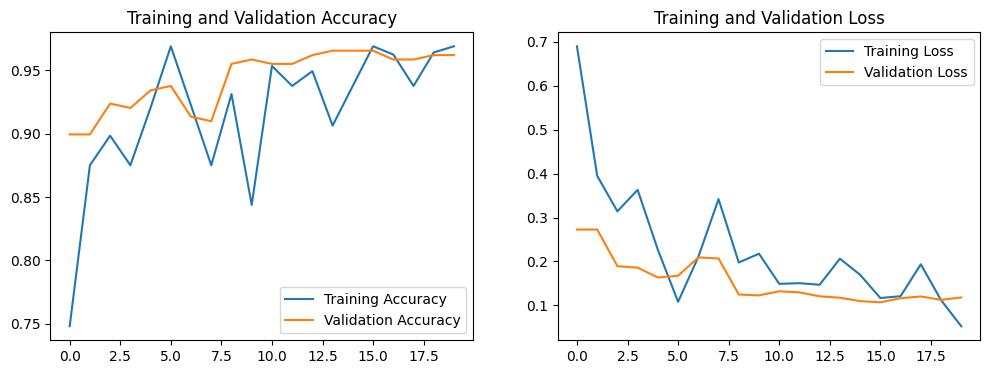

13/13 ━━━━━━━━━━━━━━━━━━━━ 158s 12s/step


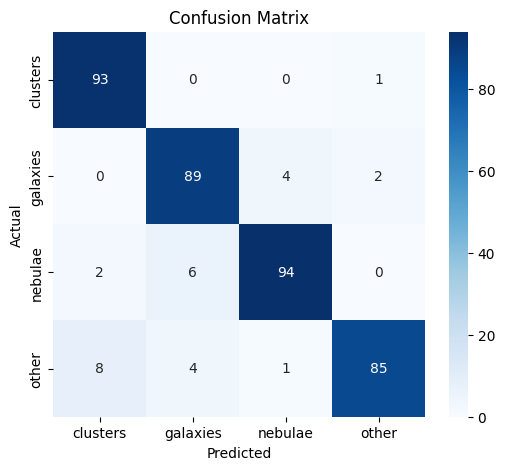

Classification Report:
              precision    recall  f1-score   support

    clusters       0.90      0.99      0.94        94
    galaxies       0.90      0.94      0.92        95
     nebulae       0.95      0.92      0.94       102
       other       0.97      0.87      0.91        98

    accuracy                           0.93       389
   macro avg       0.93      0.93      0.93       389
weighted avg       0.93      0.93      0.93       389



In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)

y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


## 5.2 Final Evaluation on the Test Set

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 73s 5s/step - accuracy: 0.9622 - loss: 0.1070
Test Loss: 0.21255716681480408
Test Accuracy: 0.9280205368995667


# 8. Fine-Tuning the Top ResNet Layers

We now unfreeze the last few layers of ResNet-50 and fine-tune them with a lower learning rate.

In [ ]:
for layer in base_model.layers[-10:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_epochs = 3
total_epochs = 10 + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size
)


13/13 ━━━━━━━━━━━━━━━━━━━━ 88s 6s/step - accuracy: 0.9622 - loss: 0.1070

🌟 Final Test Accuracy: 0.9280
🧨 Final Test Loss: 0.2126

13/13 ━━━━━━━━━━━━━━━━━━━━ 78s 6s/step


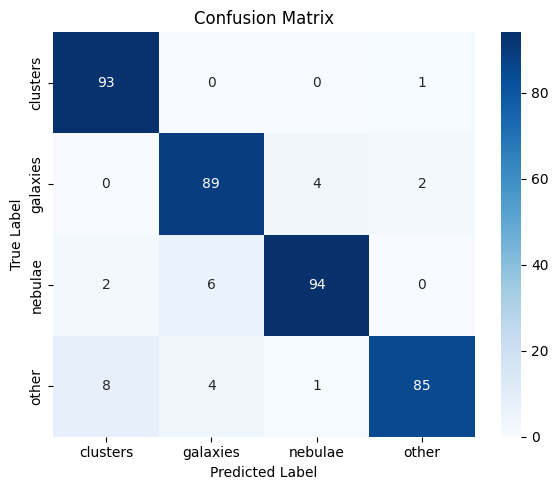

📊 Classification Report:
              precision    recall  f1-score   support

    clusters       0.90      0.99      0.94        94
    galaxies       0.90      0.94      0.92        95
     nebulae       0.95      0.92      0.94       102
       other       0.97      0.87      0.91        98

    accuracy                           0.93       389
   macro avg       0.93      0.93      0.93       389
weighted avg       0.93      0.93      0.93       389


🧾 Report in DataFrame format:
              precision  recall  f1-score  support
clusters           0.90    0.99      0.94    94.00
galaxies           0.90    0.94      0.92    95.00
nebulae            0.95    0.92      0.94   102.00
other              0.97    0.87      0.91    98.00
accuracy           0.93    0.93      0.93     0.93
macro avg          0.93    0.93      0.93   389.00
weighted avg       0.93    0.93      0.93   389.00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"\n Final Test Accuracy: {test_acc:.4f}")
print(f" Final Test Loss: {test_loss:.4f}\n")

test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes


class_names = list(test_generator.class_indices.keys())
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print("\n🧾 Report in DataFrame format:")
print(df_report.round(2))


# 9. Saving the Model

In [ ]:
model.save('/content/drive/MyDrive/Transfer Learning in Astronomy/Models/resnet50-20ep-ft.keras')

## * Embeddings (Optional, needed for application out-of-distribution filtering)

In [ ]:
def save_embeddings(model, dataset_dir, embedding_layer_name, model_name, output_drive_path):
    embedding_model = Model(inputs=model.input, outputs=model.get_layer(embedding_layer_name).output)

    embeddings = []
    filenames = []

    for root, dirs, files in os.walk(dataset_dir):
        for fname in tqdm(files, desc=f"Processing"):
            fpath = os.path.join(root, fname)
            try:
                img = image.load_img(fpath, target_size=(224, 224))
                img_array = image.img_to_array(img)
                img_array = tf.keras.applications.imagenet_utils.preprocess_input(img_array)
                img_array = np.expand_dims(img_array, axis=0)

                emb = embedding_model.predict(img_array, verbose=0)
                embeddings.append(emb.flatten())
                relative_path = os.path.relpath(fpath, dataset_dir)
                filenames.append(relative_path)
            except Exception as e:
                print(f"Skipping {fname}: {e}")

    embeddings = np.array(embeddings)

    save_path = os.path.join(output_drive_path, f"{model_name}_embeddings.npz")
    np.savez_compressed(save_path, embeddings=embeddings, filenames=filenames)
    print(f"Saved {len(embeddings)} embeddings to {save_path}")


In [ ]:
dataset_dir = '/content/drive/MyDrive/Transfer Learning in Astronomy/ODATA_final'
output_drive_path = '/content/drive/MyDrive/Transfer Learning in Astronomy/Embeddings'
os.makedirs(output_drive_path, exist_ok=True)

embedding_layer_name = 'dense'
model_name = 'resnet'

save_embeddings(model, dataset_dir, embedding_layer_name, model_name, output_drive_path)

### Load the embeddings & see T-SNE

In [ ]:
data = np.load('/content/drive/MyDrive/Transfer Learning in Astronomy/Embeddings/resnet_embeddings.npz')
embeddings = data['embeddings']
filenames = data['filenames']

labels = [f.decode().split(os.sep)[-2] if isinstance(f, bytes) else f.split(os.sep)[-2] for f in filenames]

class_to_color = {
    'clusters': 'green',
    'galaxies': 'blue',
    'nebulae': 'purple',
    'other': 'orange'
}
colors = [class_to_color.get(label, 'gray') for label in labels]

tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca')
tsne_results = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 7))
for label in class_to_color:
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=label, alpha=0.6)

plt.title("t-SNE visualization of ResNet50 Embeddings")
plt.legend()
plt.grid(True)
plt.show()


### Predict similarity on input image

In [ ]:
def predict_similarity(input_img_path, model, embedding_layer_name, embeddings_path, threshold=0.85):
    data = np.load(embeddings_path)
    gallery_embeddings = data['embeddings']
    gallery_filenames = data['filenames']

    embedding_model = Model(inputs=model.input, outputs=model.get_layer(embedding_layer_name).output)

    img = image.load_img(input_img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.imagenet_utils.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    input_embedding = embedding_model.predict(img_array)[0].reshape(1, -1)

    similarities = cosine_similarity(input_embedding, gallery_embeddings)[0]
    max_similarity = np.max(similarities)
    most_similar_index = np.argmax(similarities)
    most_similar_file = gallery_filenames[most_similar_index]

    is_dso = max_similarity >= threshold

    print(f"Most similar file: {most_similar_file}")
    print(f"Similarity score: {max_similarity:.4f}")
    print(f"In-distribution (DSO): {'Yes' if is_dso else 'No'}")
    return is_dso, max_similarity, most_similar_file


In [ ]:
img_path = '/content/drive/MyDrive/Transfer Learning in Astronomy/dark_sky_stars_191.jpg'
embeddings_path = '/content/drive/MyDrive/Transfer Learning in Astronomy/Embeddings/resnet_embeddings.npz'

embedding_layer_name = 'dense'
threshold = 0.80


predict_similarity(img_path, model, embedding_layer_name, embeddings_path, threshold)
